In [2]:
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split, DataLoader, SubsetRandomSampler, Subset, ConcatDataset
import os
from Truncate import truncate
from BSI_Entropy import BSIE
import numpy as np

In [3]:
# Download the 60000 Cifar-10 images
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

Using downloaded and verified file: .\cifar10.tgz


Create a folder named data to hold our 50000 training images and 10000 testing images

In [4]:
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

The Cifar-10 dataset is extracted to the directory data/cifar10. It contains 2 folders train and test, containing the training set (50000 images) and test set (10000 images) respectively. Each of them contains 10 folders, one for each class of images. Let's verify this using os.listdir (list the names of directories).

In [5]:
data_dir = './data/cifar10'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


There are an equal number of images for each class, 5000 for each class in the training set and 1000 for each class in the test set.

In [6]:
airplane_images = os.listdir(data_dir + "/train/airplane")
print('Number of training examples for airplanes class:', len(airplane_images))

Number of training examples for airplanes class: 5000


In [7]:
ship_test_images = os.listdir(data_dir + "/test/ship")
print("Number of test examples for ship class:", len(ship_test_images))

Number of test examples for ship class: 1000


##### The above directory structure (one folder per class) is used by many computer vision datasets, and most deep learning libraries provide utilites for working with such datasets. We can use the ImageFolder class from torchvision to load the image data as PyTorch tensors.

In [8]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [9]:
training_dataset = ImageFolder(data_dir+'/train', transform=ToTensor())

We can display one image:

In [10]:
img, label = training_dataset[49399]
print(label)
img

9


tensor([[[0.1490, 0.1647, 0.1843,  ..., 0.3373, 0.2941, 0.2235],
         [0.0902, 0.0784, 0.0941,  ..., 0.3333, 0.2745, 0.2039],
         [0.1922, 0.1569, 0.1765,  ..., 0.3294, 0.2667, 0.1922],
         ...,
         [0.4902, 0.4980, 0.5137,  ..., 0.4000, 0.3333, 0.2627],
         [0.3922, 0.4000, 0.4196,  ..., 0.4392, 0.4275, 0.4078],
         [0.3216, 0.3255, 0.3451,  ..., 0.3961, 0.4039, 0.4157]],

        [[0.2824, 0.3059, 0.3294,  ..., 0.4431, 0.4078, 0.3216],
         [0.2235, 0.2314, 0.2431,  ..., 0.4392, 0.3882, 0.2902],
         [0.3569, 0.3373, 0.3373,  ..., 0.4353, 0.3686, 0.2706],
         ...,
         [0.4392, 0.4314, 0.4510,  ..., 0.3451, 0.2902, 0.2353],
         [0.3608, 0.3647, 0.3843,  ..., 0.3843, 0.3804, 0.3608],
         [0.3098, 0.3176, 0.3333,  ..., 0.3569, 0.3569, 0.3569]],

        [[0.5490, 0.5725, 0.5882,  ..., 0.7176, 0.6706, 0.6157],
         [0.5059, 0.5137, 0.5137,  ..., 0.7137, 0.6549, 0.5765],
         [0.6627, 0.6392, 0.6353,  ..., 0.7137, 0.6471, 0.

In [11]:
print(training_dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### Same reason here, we load our testing image data as PyTorch tensors

In [12]:
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())
len(test_dataset)

10000

### In the following section, we load in our pretrained CNN model serving as our embedding function to extract feature space from the image data

In [13]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [14]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [15]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [16]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 64),
            nn.ReLU(),
            nn.Linear(64, 10)) # this is the final CNN layer before classification prediction 
                                # (the one produce M features in Mr.Diggans' letter) and in this case M = 10
        
    def forward(self, xb):
        return self.network(xb)

In [17]:
device = get_default_device()
device

device(type='cpu')

In [18]:
model = to_device(Cifar10CnnModel(), device)

In [19]:
model.load_state_dict(torch.load('cifar10-cnn.pth')) # load our pretrained model

<All keys matched successfully>

In [20]:
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [21]:
from torch.utils.data.dataloader import DataLoader
batch_size=128
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
evaluate(model, test_loader)

{'val_loss': 0.9372484087944031, 'val_acc': 0.7689453363418579}

### After loading in our embedding function, we can test whether it can extract the intermediate feature successfully by inputting one image from our training set

In [22]:
features = {}
def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()

    return hook

In [23]:
model.network[18].register_forward_hook(get_features('18'))

In [24]:
img, label = training_dataset[36666]
label

7

In [25]:
output = model(to_device(img.unsqueeze(0), device))

In [26]:
features['18']

tensor([[-17.1250,  -2.6508, -20.5190, -21.7576,  -6.1672,  -4.2082, -18.6081,
          -8.5854,  -4.3932, -19.4672,  -4.1187, -17.1577, -13.7157, -11.8042,
          -6.0299, -16.6095,  33.7439,  -5.3955, -10.6941, -16.5395,  10.8451,
         -12.4619,  26.5413, -10.2965, -11.3364,  12.2312,  -4.2819,  18.3797,
          -8.7769,  -8.9047, -22.7475, -24.0030,  -3.2923,  -8.8365,  19.1856,
          -8.4078,   0.9128,  -6.7034,  -4.5636, -11.3492,  -4.9906,  -4.7368,
          -6.1834,  -6.2606,  -9.2778,  -7.9591,  -8.0501, -12.8337,  -6.1143,
         -13.8880,  -8.8909,  -4.9458,  -5.0991,  -6.1092,  26.6735, -12.8832,
         -16.6240, -14.6230,  22.4230,  -7.9574, -14.2497, -11.5065,  -6.9942,
          -9.9396]])

## Now, we can establish the feature space for each class in Cifar-10 training set

In [27]:
# ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

class_feature_data = {label: [] for label in range(10)}

In [28]:
for image, label in training_dataset:
    if label in class_feature_data:
        output = model(to_device(image.unsqueeze(0), device))
        class_feature_data[label].append(features['18'])

In [29]:
for label in class_feature_data:
    class_feature_data[label] = torch.cat(class_feature_data[label], dim = 0).T 
    

### We can further find the singular vector and entropy value for feature space of each training class

In [30]:
singular_vector = {label: torch.svd(class_feature_data[label])[1] for label in class_feature_data}

In [31]:
singular_vector

{0: tensor([8305.8789, 1585.3182, 1073.5406,  963.0099,  828.8642,  769.5621,
          616.4266,  580.3412,  516.1616,  488.6954,  402.4275,  341.2084,
          275.5750,  266.5753,  257.8827,  231.7271,  198.1219,  183.4829,
          180.9243,  177.5941,  156.9813,  144.6703,  141.9810,  132.6933,
          126.5861,  122.6644,  117.9465,  113.8699,  110.0822,  106.3363,
          103.7124,   93.6782,   91.7617,   89.5256,   84.1956,   82.4179,
           80.3859,   78.2227,   75.4202,   72.8308,   71.0707,   69.9203,
           65.3629,   64.8393,   62.6921,   60.4378,   58.1620,   56.9152,
           54.7706,   54.1711,   52.7214,   51.6815,   50.4430,   49.4335,
           47.0124,   45.7740,   43.8802,   43.6093,   42.2480,   40.5315,
           39.1501,   37.6497,   36.0807,   34.7374]),
 1: tensor([12095.2061,  1403.4337,  1103.4655,   963.6672,   940.5552,   853.0527,
           744.2352,   670.6514,   567.7023,   496.4117,   435.3126,   407.3419,
           350.2057,   277.

In [32]:
entropy = {label: BSIE(truncate(singular_vector[label], 3), [0, float('nan')]).item() for label in singular_vector}
print(entropy)

{0: 0.7522338164816981, 1: 0.7164786375096308, 2: 0.7705121005378595, 3: 0.7549243843017072, 4: 0.7589535094709319, 5: 0.7425858237466618, 6: 0.7425237755562969, 7: 0.7394834090879348, 8: 0.7432928614572687, 9: 0.727277486877264}


#### We can load in the training dataset of 50000 class by class below and store all of them in a dictionary

In [33]:
classes = {0: (0, 5000), 1:(5000, 10000), 2:(10000, 15000), 3:(15000, 20000), 4:(20000, 25000), 5:(25000, 30000), 6:(30000, 35000), 7:(35000, 40000), 8:(40000, 45000), 9:(45000, 50000)}
training_data_by_class = {category: Subset(ImageFolder('./data/cifar10/train/', transform=ToTensor()), range(classes[category][0], classes[category][1])) for category in classes}


#### By default, we select 500 images from each class in our training data and combine them to train a new CNN model

In [34]:

def select_subsample(classified_training_data, n_sample = 500): 
    subsample = {i: random_split(classified_training_data[i], [n_sample, len(classified_training_data[i]) - n_sample])[0] for i in classified_training_data}
    return subsample
    

In [35]:
subsample_500 = select_subsample(training_data_by_class)
len(subsample_500[7]) # that is, we have 500 image-label pairs in class 7

500

In [36]:
subsample_500[9][4][0]

tensor([[[0.3529, 0.3490, 0.3647,  ..., 0.3490, 0.3608, 0.5216],
         [0.3529, 0.3529, 0.3686,  ..., 0.3490, 0.3608, 0.4667],
         [0.3725, 0.3647, 0.3765,  ..., 0.3608, 0.3686, 0.4510],
         ...,
         [0.6353, 0.6118, 0.6118,  ..., 0.6196, 0.6078, 0.6510],
         [0.7961, 0.7765, 0.7804,  ..., 0.7686, 0.7686, 0.7843],
         [0.9098, 0.9059, 0.9059,  ..., 0.9020, 0.9020, 0.9098]],

        [[0.5882, 0.6000, 0.6039,  ..., 0.6078, 0.5961, 0.6510],
         [0.5922, 0.6078, 0.6118,  ..., 0.6118, 0.6000, 0.5961],
         [0.6118, 0.6196, 0.6275,  ..., 0.6235, 0.6118, 0.5882],
         ...,
         [0.6353, 0.6118, 0.6118,  ..., 0.6196, 0.6078, 0.6510],
         [0.7961, 0.7765, 0.7804,  ..., 0.7686, 0.7686, 0.7843],
         [0.9098, 0.9059, 0.9059,  ..., 0.9020, 0.9020, 0.9098]],

        [[0.7529, 0.7647, 0.7529,  ..., 0.7765, 0.7569, 0.7333],
         [0.7569, 0.7686, 0.7608,  ..., 0.7804, 0.7608, 0.6863],
         [0.7765, 0.7843, 0.7725,  ..., 0.7882, 0.7765, 0.

In [37]:
for img, label in random_split(training_dataset, [49990, 10])[1]:
    print(label)

7
6
4
6
3
6
1
2
8
1


#### Then we can also compute the entropy value for each class subset and store them into a dictionary, but first we should get the feature space of the subset of each class

In [38]:
subset_feature = {category: [] for category in subsample_500}

for category in subsample_500:
    for img, label in subsample_500[category]:
        output = model(to_device(img.unsqueeze(0), device))
        subset_feature[label].append(features['18'])

           

In [39]:
for label in subset_feature:
    subset_feature[label] = torch.cat(subset_feature[label], dim = 0).T 

In [40]:
subset_feature[8].shape

torch.Size([64, 500])

#### From the subset feature space of each class, we can get the entropy value for each subset class

In [41]:
subset_singular_vector = {label: torch.svd(subset_feature[label])[1] for label in subset_feature}

In [42]:
subset_entropy = {label: BSIE(truncate(subset_singular_vector[label], 3), [0, float('nan')]).item() for label in subset_singular_vector}
subset_entropy

{0: 0.7540928303945171,
 1: 0.7216651008432696,
 2: 0.7752456053919772,
 3: 0.7556253710915124,
 4: 0.7573073136757312,
 5: 0.7451214958553789,
 6: 0.7313736665594192,
 7: 0.7346624985078555,
 8: 0.7443108041732241,
 9: 0.7325014300376521}

#### Entropy difference between each class of 5000 and its subset of 500

In [43]:
entropy_diff = {label: np.abs(entropy[label] - subset_entropy[label])/entropy[label] for label in entropy}
entropy_diff

{0: 0.002471324569684901,
 1: 0.007238824805253314,
 2: 0.006143323188323033,
 3: 0.0009285523217714542,
 4: 0.0021690337743456925,
 5: 0.0034146519198596246,
 6: 0.01501650097133133,
 7: 0.006519295119853056,
 8: 0.001369504227391233,
 9: 0.0071828748375236005}

#### Then we can combine all of each class subset of 500 to train CNN

In [44]:

cifar10sub = ConcatDataset([subsample_500[class_name] for class_name in subsample_500])

In [45]:
len(cifar10sub)

5000

#### Data Loader

In [46]:
cifar10sub_loader = DataLoader(cifar10sub, batch_size = batch_size, shuffle = True, pin_memory = True)
cifar10sub_train_loader = DeviceDataLoader(cifar10sub_loader, device)

In [47]:
random_seed = 42
torch.manual_seed(random_seed);

In [48]:

val_size = 5000
train_size = len(training_dataset) - val_size

train_ds, val_ds = random_split(training_dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [49]:
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [50]:
num_epochs = 15
opt_func = torch.optim.Adam
lr = 0.001
model = to_device(Cifar10CnnModel(), device)

In [51]:
history = fit(num_epochs, lr, model, cifar10sub_train_loader, val_dl, opt_func)

Epoch [0], train_loss: 2.2805, val_loss: 2.1816, val_acc: 0.1515
Epoch [1], train_loss: 2.0766, val_loss: 2.0716, val_acc: 0.2220
Epoch [2], train_loss: 1.9531, val_loss: 2.0896, val_acc: 0.2434
Epoch [3], train_loss: 1.8082, val_loss: 1.7448, val_acc: 0.3138
Epoch [4], train_loss: 1.6875, val_loss: 1.7925, val_acc: 0.3212
Epoch [5], train_loss: 1.6192, val_loss: 1.6130, val_acc: 0.3861
Epoch [6], train_loss: 1.5532, val_loss: 1.5676, val_acc: 0.4141
Epoch [7], train_loss: 1.4969, val_loss: 1.6884, val_acc: 0.3926
Epoch [8], train_loss: 1.4454, val_loss: 1.4568, val_acc: 0.4623
Epoch [9], train_loss: 1.3349, val_loss: 1.3949, val_acc: 0.4858
Epoch [10], train_loss: 1.2601, val_loss: 1.4453, val_acc: 0.4815
Epoch [11], train_loss: 1.2108, val_loss: 1.4306, val_acc: 0.4905
Epoch [12], train_loss: 1.1182, val_loss: 1.4275, val_acc: 0.4999
Epoch [13], train_loss: 1.0606, val_loss: 1.4567, val_acc: 0.4928
Epoch [14], train_loss: 0.9861, val_loss: 1.3677, val_acc: 0.5375


In [52]:
classes = {0: (0, 1000), 1:(1000, 2000), 2:(2000, 3000), 3:(3000, 4000), 4:(4000, 5000), 5:(5000, 6000), 6:(6000, 7000), 7:(7000, 8000), 8:(8000, 9000), 9:(9000, 10000)}
test_data_by_class = {category: Subset(ImageFolder('./data/cifar10/test/', transform=ToTensor()), range(classes[category][0], classes[category][1])) for category in classes}


In [53]:

test_accuracy_by_class = {label: [] for label in test_data_by_class}

for label in test_data_by_class:
    test_data = training_data_by_class[label]
    test_loader = DeviceDataLoader(DataLoader(test_data, batch_size*2), device)
    result = evaluate(model, test_loader)
    result
    test_accuracy_by_class[label] = result['val_acc']

In [54]:
test_accuracy_by_class

{0: 0.603320300579071,
 1: 0.7005055546760559,
 2: 0.3923138976097107,
 3: 0.22620634734630585,
 4: 0.5449333786964417,
 5: 0.412109375,
 6: 0.4820197522640228,
 7: 0.5696461796760559,
 8: 0.7796300649642944,
 9: 0.6216452121734619}

In [55]:
import pandas as pd
df1 = pd.DataFrame(list(test_accuracy_by_class.items()), columns=['class', 'Test_Accuracy'])
df2 = pd.DataFrame(list(entropy_diff.items()), columns=['class', 'Entropy_difference'])

In [56]:
df2, df1

(   class  Entropy_difference
 0      0            0.002471
 1      1            0.007239
 2      2            0.006143
 3      3            0.000929
 4      4            0.002169
 5      5            0.003415
 6      6            0.015017
 7      7            0.006519
 8      8            0.001370
 9      9            0.007183,
    class  Test_Accuracy
 0      0       0.603320
 1      1       0.700506
 2      2       0.392314
 3      3       0.226206
 4      4       0.544933
 5      5       0.412109
 6      6       0.482020
 7      7       0.569646
 8      8       0.779630
 9      9       0.621645)

<Axes: xlabel='Entropy_difference', ylabel='Test_Accuracy'>

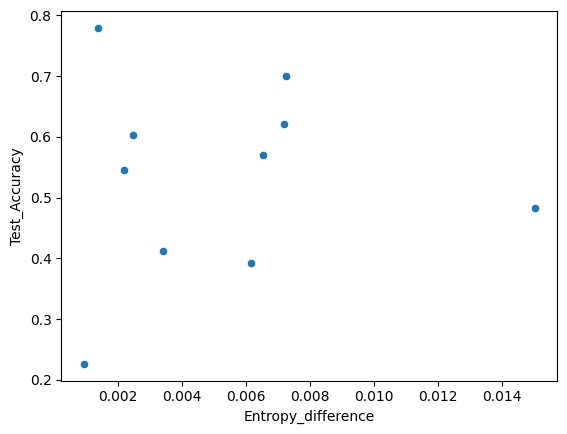

In [57]:
import seaborn as sns
merged_df = pd.merge(df1, df2, on='class')
sns.scatterplot(data=merged_df, x='Entropy_difference', y='Test_Accuracy')

#### After running the code a few more times, there are some correlation that whenever the entropy difference between a subsample and a class grows large, then test set accuracy on that class decreases if we use the subsample as part of our training set. 